In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.stem.porter import PorterStemmer
import random
from sklearn.model_selection import train_test_split

data = pd.read_csv('../datasets/spam_ham.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
# Drop unwanted columns and rename remaining columns
if len(data.columns) > 3: 
    data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
if data.columns[0] != 'label':
    data = data.rename(columns={'v1': 'label', 'v2': 'text'})
data.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Count observations in each label
data.label.value_counts()
#data.info()

ham     4825
spam     747
Name: label, dtype: int64

In [4]:
# Convert label to numerical variable
data['label_num'] = data.label.map({'ham': 0, 'spam': 1})
data.head()

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:
# Extract every text 
texts = []
for index, row in data.iterrows():
    texts.append((row['text'], row['label_num']))
texts[:5]

[('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  0),
 ('Ok lar... Joking wif u oni...', 0),
 ("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
  1),
 ('U dun say so early hor... U c already then say...', 0),
 ("Nah I don't think he goes to usf, he lives around here though", 0)]

In [6]:
# * * * PREPROCESSING * * * 
# Remove whitespace and punctutation 
tokenized = []
for t in texts:
    m = t[0]
    text = re.sub('[' + string.punctuation + ']', ' ', m)
    text = re.sub('[\n\t\r]', '', text)
    words = text.split()
    tokenized.append((words, t[1]))


In [7]:
# Remove stopwords
stopwords = []
try:
    f = open('../datasets/stopwords.txt', 'r')
    stopwords = f.read().split(',')
except IOError:
    print('Problem opening file')
finally:
    f.close()
print(stopwords[50])
#stopwords[:10]
#l = [(['yes', 'almost', 'free'], 0), (['hello'], 1)]
filtered = []
for t in tokenized:
    text = t[0]
    f_text = []
    for word in text:
        if word not in stopwords and len(word) > 2:
            f_text.append(word)
    filtered.append((f_text, t[1]))

filtered[51]

is


(['gram',
  'usually',
  'runs',
  'half',
  'eighth',
  'smarter',
  'though',
  'gets',
  'whole',
  'second',
  'gram'],
 0)

In [8]:
# Stem the words
stemmer = PorterStemmer()
stemmed = []
for t in filtered:
    text = t[0]
    stemmed_text = []
    for word in text:
        stemmed_word = stemmer.stem(word.lower())
        stemmed_text.append(stemmed_word)
    stemmed.append((stemmed_text, t[1]))

stemmed[51]

(['gram',
  'usual',
  'run',
  'half',
  'eighth',
  'smarter',
  'though',
  'get',
  'whole',
  'second',
  'gram'],
 0)

In [9]:
# Counting occurences of words, removing the ones only occuring once
word_count = {}
for t in stemmed:
    text = t[0]
    for word in text:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
            
print(stemmed[0])

for t in stemmed:
    text = t[0]
    text = list(filter(lambda x: word_count[x] > 1, text))
for i in range(len(stemmed)):
    text = stemmed[i][0]
    #print(text)
    stemmed[i] = (list(filter(lambda x: word_count[x] > 1, text)), stemmed[i][1])
    
print(stemmed[0])

(['until', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'great', 'world', 'buffet', 'cine', 'amor', 'wat'], 0)
(['until', 'point', 'crazi', 'avail', 'bugi', 'great', 'world', 'buffet', 'cine', 'wat'], 0)


In [10]:
# Splitting data in trainingdata and testdata (80-20 ratio)
totaltexts = data.label.value_counts()
total = totaltexts[0] + totaltexts[1] # Total number of texts
test_number = int(0.20 * total) # Number of testing mails
# Picking randomly
test_set = []
taken = {}
while len(test_set) < test_number:
    #print(len(train_texts))
    num = random.randint(0, test_number - 1)
    if num not in taken.keys():
        test_set.append(stemmed.pop(num))
        taken[num] = 1

train_set = stemmed # Trainset is the remaining texts
        
# Total number of hams and spams
hams = data.label.value_counts()[0]
spams = data.label.value_counts()[1]

len(train_set)/total, len(test_set)/total

(0.80007178750897345, 0.19992821249102657)

###### Probability that a text containing a given word is spam (Bayes' theorem):
$P(Spam|Word) =  \frac{P(Word|Spam)P(Spam)}{P(Word|Spam)P(Spam) + P(Word|Ham)P(Ham)} $

In [11]:
# * * * TRAINING THE MODEL * * * 

# meaning: Computing probabilities needed for P(Spam|Word)


# 1) Probability that a word appears in spam messages
# 2) Probability that a word appears in ham messages


def p_appears_in_spam(word):
    count = 0
    total_spams = 0
    for t in train_set:
        text = t[0]
        if t[1] == 1:
            total_spams += 1
            if word in text:
                count += 1
    return count/total_spams
             

def p_appears_in_ham(word):
    count = 0
    total_hams = 0
    for t in train_set:
        text = t[0]
        if t[1] == 0:
            total_hams += 1
            if word in text:
                count += 1
    return count/total_hams

# 3) Overall probability that any given message is spam
# 4) Overall probability that any given message is not spam (is ham)

def total_spams_and_hams(tset):
    spams = 0
    hams = 0
    for t in tset:
        spams += 1 if t[1] == 1 else 0
        hams += 1 if t[1] == 0 else 0
    return spams, hams


p_spam = total_spams_and_hams(train_set)[0]/len(train_set)
p_ham = total_spams_and_hams(train_set)[1]/len(train_set)

# Finally we can compute P(Spam | Word)
def p_is_spam_given_word(word):
    return (p_appears_in_spam(word)*p_spam)/((p_appears_in_spam(word)*p_spam + p_appears_in_ham(word)*p_ham))

p_is_spam_given_word('free')

0.7197802197802198

In [12]:
# COMBINING INDIVIDUAL PROBABILITIES
# Determining whether a message is spam or ham based only on the presence of one word is error-prone,
# must try to consider all the words (or the most interesting) in the message

###### Probability that a text is spam:
$P(Spam) =  \frac{p_1p_2...p_n}{p_1p_2...p_n + (1-p_1)(1-p_2)...(1-p_n)} $

$p_1$: The probability $P(S|W_1)$, that it is spam knowing it contains a first word (for example "free")

Time to collect the the different probabilities $p_1, p_2, ... , p_n$

In [13]:
probabilities = {}
for t in train_set:
    text = t[0]
    for word in text:
        if word not in probabilities:
            p = p_is_spam_given_word(word)
            if p == 0:
                probabilities[word] = 0.2 # tweaking this value
            elif p == 1:
                probabilities[word] = 0.98 # tweaking this value
            else:
                probabilities[word] = p

In [14]:
from functools import reduce
def p_is_spam(words):
    words = list(filter(lambda x: x in probabilities, words))
    probs = []
    for word in words:
        if word in probabilities:
            probs.append(probabilities[word])
        else:
            probs.append(0.4) # tweaking this value
    probs_not = list(map(lambda prob: 1-prob, probs))
    product = reduce(lambda x, y: x * y, probs, 1) 
    product_not = reduce(lambda x, y: x * y, probs_not, 1)
    return product/(product + product_not)


In [15]:
# * * * TESTING THE MODEL * * * 
total_correct = 0

true_spam_as_spam = 0
true_spam_as_ham = 0

true_ham_as_ham = 0
true_ham_as_spam = 0

# Care most about minimizing false positives, that is: labeling non-spam messages as spam
false_positives = []

for t in test_set:
    guess = -1
    words = t[0]
    answer = t[1]
    p_spam = p_is_spam(words)
    # If p > 0.95, predict 'yes' (is spam)
    guess = 1 if p_spam > 0.95 else 0
    if guess == answer:
        total_correct += 1
        if answer == 0: # true negative
            true_ham_as_ham += 1
        else: # true positive
            true_spam_as_spam += 1 
    else:
        if answer == 0: # false positive
            true_ham_as_spam += 1
            false_positives.append((words, p_spam))
        else: # true negative
            true_spam_as_ham += 1

            
true_spams = total_spams_and_hams(test_set)[0]
true_hams = total_spams_and_hams(test_set)[1]

print('Total test texts: ', len(test_set))
print('Number of correct: ', total_correct)
print('Accuracy: ', total_correct*100/(true_spams+true_hams))
print('-------------------------------')
print('Ham precision: ', true_ham_as_ham/(true_ham_as_ham + true_spam_as_ham))
print('Ham recall: ', true_ham_as_ham/(true_ham_as_ham + true_ham_as_spam))
print('Spam precision: ', true_spam_as_spam/(true_spam_as_spam + true_ham_as_spam)) # Most important 
print('Spam recall: ', true_spam_as_spam/(true_spam_as_spam + true_spam_as_ham))
print('-------------------------------')
print('false positives:')
for text, p in false_positives:
    print(text, p)


Total test texts:  1114
Number of correct:  1089
Accuracy:  97.75583482944344
-------------------------------
Ham precision:  0.9763374485596708
Ham recall:  0.9978969505783386
Spam precision:  0.9859154929577465
Spam recall:  0.8588957055214724
-------------------------------
false positives:
['fan'] 0.98
['26th', 'juli'] 0.98


In [16]:
# * * * VISUALISATIONS * * * 
from wordcloud import WordCloud

spam_words = ""
ham_words = ""

all = train_set + test_set

for t in all:
    text = t[0]
    s = ""
    for word in text:
        s += word + ' '
    if t[1] == 0:
        ham_words += s
    else:
        spam_words += s + ' '

# # Generate a word cloud image
spam_wordcloud = WordCloud(width=600, height=400).generate(spam_words)
ham_wordcloud = WordCloud(width=600, height=400).generate(ham_words)


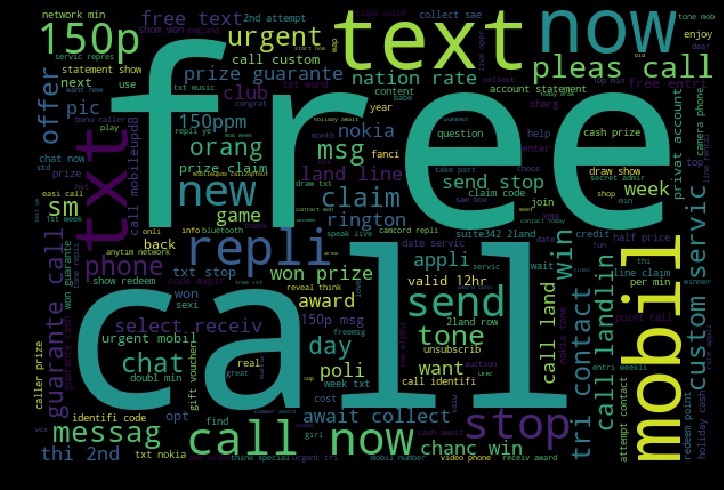

In [17]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

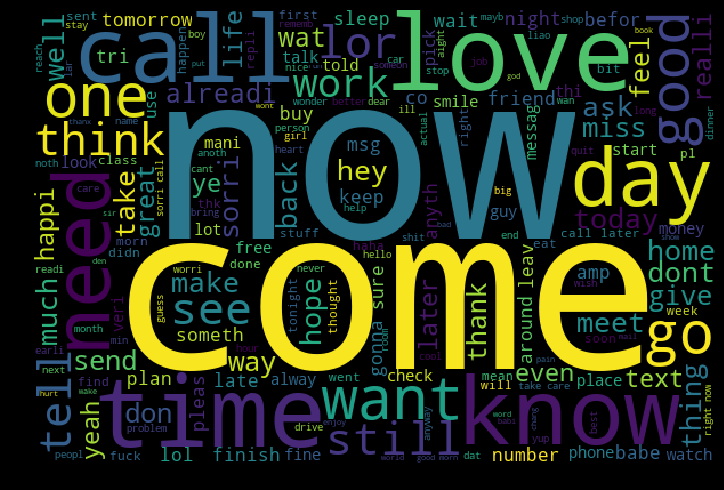

In [18]:
# Ham Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)